In [2]:
from typing import cast

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import callbacks, layers, models
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


2025-12-07 14:11:44.281634: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 14:11:44.335877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 14:11:43.197408: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
tf.random.set_seed(123)

wordlist = set(pd.read_csv("input_data/words.csv", encoding="UTF-8")["words"])
mails = pd.read_csv("input_data/enron_spam_data.csv")
mails.drop(labels=["Message ID", "Date", "Subject"], axis=1, inplace=True)
mails.dropna(subset=["Message"], inplace=True)
mails.rename(
    columns={"Message": "message", "Spam/Ham": "spam"},
    inplace=True,
)
mails["spam"] = mails["spam"].map(lambda spam_ham: True if spam_ham == "spam" else False)

mails_split = train_test_split(mails, test_size=0.2, random_state=123, shuffle=True)
train_data, test_data = cast(tuple[pd.DataFrame, pd.DataFrame], mails_split)
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

nltk.download("stopwords")
nltk.download("punkt_tab")
stop_words = stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lateridiot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lateridiot/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def clean_message(text: str) -> str:
    text = text.lower()
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    filtered = [
        stemmer.stem(w)
        for w in tokens
        if w.isalpha() and w not in stop_words and w in wordlist
    ]
    return " ".join(filtered)


train_data["clean"] = train_data["message"].apply(clean_message)
test_data["clean"] = test_data["message"].apply(clean_message)
train_data = train_data[train_data["clean"].str.len() > 0].reset_index(drop=True)
test_data = test_data[test_data["clean"].str.len() > 0].reset_index(drop=True)


In [5]:
max_words = 20000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["clean"])

X_train_seq = tokenizer.texts_to_sequences(train_data["clean"])
X_test_seq = tokenizer.texts_to_sequences(test_data["clean"])

X_train = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

y_train = train_data["spam"].astype(int).to_numpy()
y_test = test_data["spam"].astype(int).to_numpy()


In [83]:
model = models.Sequential(
    [
        layers.Embedding(max_words, 512),
        layers.GlobalAveragePooling1D(),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    verbose="auto",
)


Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6197 - loss: 0.6007 - val_accuracy: 0.5978 - val_loss: 0.4683
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8623 - loss: 0.2966 - val_accuracy: 0.9234 - val_loss: 0.1745
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9448 - loss: 0.1352 - val_accuracy: 0.9567 - val_loss: 0.0995
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9523 - loss: 0.1227 - val_accuracy: 0.9488 - val_loss: 0.1264
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9592 - loss: 0.1043 - val_accuracy: 0.9573 - val_loss: 0.1087
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9684 - loss: 0.0813 - val_accuracy: 0.9656 - val_loss: 0.1021
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9691 - loss: 0.0790 - val_accuracy: 0.9476 - val_loss: 0.1330
Epoch 8/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9694 - loss: 0.0790 - val_accuracy: 0.

In [84]:
probs = model.predict(X_test).ravel()
predictions = probs >= 0.5

print(classification_report(y_test, predictions, target_names=["Ham", "Spam"], digits=4))


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         Ham     0.9817    0.9634    0.9725      3171
        Spam     0.9668    0.9834    0.9750      3433

    accuracy                         0.9738      6604
   macro avg     0.9742    0.9734    0.9737      6604
weighted avg     0.9739    0.9738    0.9738      6604



True Positive: 3376
False Negative: 57
True Negative: 3055
False Positive: 116


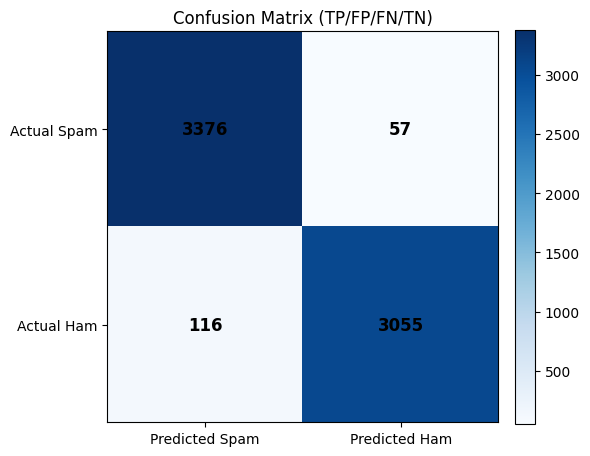

In [87]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[0, 1]).ravel()

print(f"True Positive: {tp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")

fig, ax = plt.subplots(figsize=(6, 6))
matrix = [[tp, fn], [fp, tn]]
im = ax.imshow(matrix, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Predicted Spam", "Predicted Ham"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Actual Spam", "Actual Ham"])

for (i, j), value in [((0, 0), tp), ((0, 1), fn), ((1, 0), fp), ((1, 1), tn)]:
    ax.text(j, i, f"{value}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

ax.set_title("Confusion Matrix (TP/FP/FN/TN)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


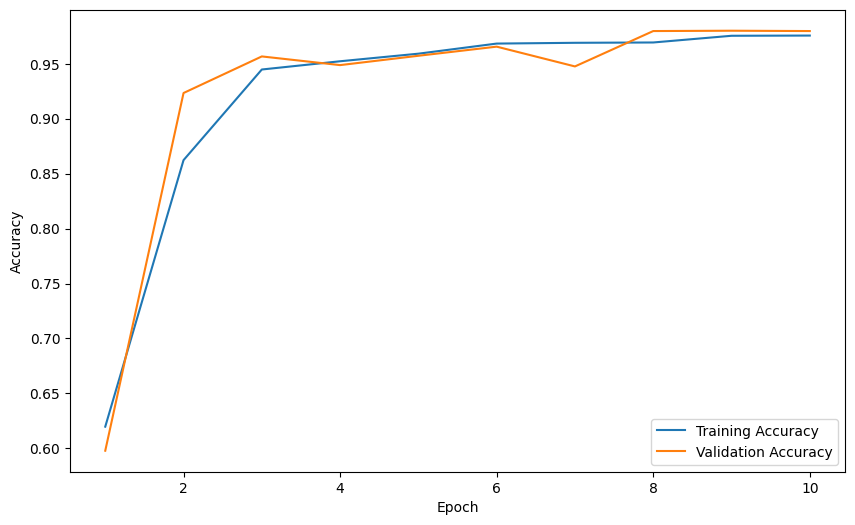

In [86]:
import re

epochs_str = """Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6197 - loss: 0.6007 - val_accuracy: 0.5978 - val_loss: 0.4683
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8623 - loss: 0.2966 - val_accuracy: 0.9234 - val_loss: 0.1745
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9448 - loss: 0.1352 - val_accuracy: 0.9567 - val_loss: 0.0995
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9523 - loss: 0.1227 - val_accuracy: 0.9488 - val_loss: 0.1264
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9592 - loss: 0.1043 - val_accuracy: 0.9573 - val_loss: 0.1087
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9684 - loss: 0.0813 - val_accuracy: 0.9656 - val_loss: 0.1021
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9691 - loss: 0.0790 - val_accuracy: 0.9476 - val_loss: 0.1330
Epoch 8/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9694 - loss: 0.0790 - val_accuracy: 0.9798 - val_loss: 0.0801
Epoch 9/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.9755 - loss: 0.0640 - val_accuracy: 0.9801 - val_loss: 0.0850
Epoch 10/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9757 - loss: 0.0617 - val_accuracy: 0.9798 - val_loss: 0.0875"""

accuracies = {
    "x": list(range(1, 11)),
    "y": list(map(lambda x: float(x), re.findall(r" accuracy: (\d.\d+)", epochs_str)))
}

val_accuracies = {
    "x": list(range(1, 11)),
    "y": list(map(lambda x: float(x), re.findall(r" val_accuracy: (\d.\d+)", epochs_str)))
}

plt.figure(figsize=(10, 6))
plt.plot(accuracies["x"], accuracies["y"], label="Training Accuracy")
plt.plot(val_accuracies["x"], val_accuracies["y"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [93]:
def predict_example(example_message: str) -> None:
    """Predict if example message is spam or ham."""
    clean_example = clean_message(example_message)
    example_seq = tokenizer.texts_to_sequences([clean_example])
    example_padded = pad_sequences(example_seq, maxlen=max_len, padding="post", truncating="post")
    prob = float(model.predict(example_padded)[0][0])
    prediction = "Spam" if prob >= 0.5 else "Ham"

    print(f"Message: {example_message}")
    print(f"Cleaned: {clean_example}")
    print(f"Predicted class: {prediction} (probability={prob:.4f})")

In [96]:
# Actual Message from my inbox
predict_example("""
Dear Nayan,

Tomorrow is the last day to complete your student evaluations of teaching.

Enhancing the student experience requires your confidential feedback for the course(s) in which you are enrolled

Please complete your course evaluations today!

IT-371-001-Applied AI for IT (Sharmin Sultana) (Open)
Due Date: Monday, December 8, 2025 11:59 PM

You can also access your evaluation(s) via Canvas or via the Blue website using the following link:

https://my-gmu.bluera.com/

The information you provide is very important. The summary results from evaluations are used to assess both curricular and instructional quality and to identify opportunities for improvement.

Your participation is truly appreciated. If you require assistance or have any questions please contact the Office of Institutional Effectiveness and Planning at oiepset@gmu.edu.
""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Message: 
Dear Nayan,

Tomorrow is the last day to complete your student evaluations of teaching.

Enhancing the student experience requires your confidential feedback for the course(s) in which you are enrolled

Please complete your course evaluations today!

IT-371-001-Applied AI for IT (Sharmin Sultana) (Open)
Due Date: Monday, December 8, 2025 11:59 PM

You can also access your evaluation(s) via Canvas or via the Blue website using the following link:

https://my-gmu.bluera.com/

The information you provide is very important. The summary results from evaluations are used to assess both curricular and instructional quality and to identify opportunities for improvement.

Your participation is truly appreciated. If you require assistance or have any questions please contact the Office of Institutional Effectiveness and Planning at oiepset@gmu.edu.

Cleaned: tomorrow last complet student evalu teach enhanc student experi requir confidenti feedback 

In [95]:
# Actual Message from my spam folder
predict_example("""
Dear user,

We attempted to renew your Cloud+ subscription, but your payment method has expired. As a result, your personal data is now at risk of being permanently removed from cloud.

What you could lose:

    Photos and videos stored in Cloud Photos
    Contacts, calendars, and reminders
    Notes, documents, and app data
    Device backups (iPhone, iPad, Mac)

ℹ️ Final Reminder:
Your data will be deleted if no action is taken by Tuesday, Nov 18 2025.

To prevent data loss, please update your payment information immediately and continue enjoying seamless access to your files across all Apple devices.
Update Payment & Secure My Data
Thank you for choosing Cloud.
— The Cloud Support Team
""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Message: 
Dear user,

We attempted to renew your Cloud+ subscription, but your payment method has expired. As a result, your personal data is now at risk of being permanently removed from cloud.

What you could lose:

    Photos and videos stored in Cloud Photos
    Contacts, calendars, and reminders
    Notes, documents, and app data
    Device backups (iPhone, iPad, Mac)

ℹ️ Final Reminder:
Your data will be deleted if no action is taken by Tuesday, Nov 18 2025.

To prevent data loss, please update your payment information immediately and continue enjoying seamless access to your files across all Apple devices.
Update Payment & Secure My Data
Thank you for choosing Cloud.
— The Cloud Support Team

Cleaned: user attempt renew subscript payment expir result person risk perman remov could photo video store photo contact calendar remind note document devic backup final remind delet action taken prevent pleas updat payment inform immedi continu enjoy 